# Deep Convolutional AutoEncoder for Lossy Image Compression


1. **Imports & Reproducibility** 
2. **Device Selection**
3. **Data Loading & Preprocessing**
4. **Model Definition** 
5. **Model Initialization & Summary**
6. **Training Loop & Dynamic Visualization**
7. **Results & Analysis**

## 1. Imports & Reproducibility


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import piq
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import csv

# For reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True



In [2]:
print(torch.backends.cudnn.is_available())  # should be True
print(torch.backends.cudnn.version())       # prints your cuDNN version


True
90100


## 2. Device Selection


In [3]:

device = torch.device("cuda" if True and torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Data Loading & Preprocessing
We'll load the three subsets (`subset_1.npy`, `subset_2.npy`, `subset_3.npy`), normalise the pixel values to `[0,1]`, and reshape them to `[N, 3, 150, 225]`. Then we'll split into training and validation sets and create PyTorch DataLoaders.

In [4]:
def load_and_reshape(path):
    data = np.load(path)
    # reshape to (150, 225, 3)
    num_images = data.shape[0]
    reshaped = data.reshape(num_images, 150, 225, 3)
    return reshaped

subset1 = load_and_reshape("subset_1.npy")
subset2 = load_and_reshape("subset_2.npy")
subset3 = load_and_reshape("subset_3.npy")
data = np.concatenate([subset1, subset2, subset3], axis=0)
print(f"Combined data shape: {data.shape}")

# normalisation
data = data.astype('float32') / 255.0

# split data into training (80%), validation (10%) and test (10%)
num_total = data.shape[0]
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)

x_train = data[:num_train]
x_val = data[num_train:num_train+num_val]
x_test = data[num_train+num_val:]

print(f"Train set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")

# convert to  tensors and rearrange to (N, C, H, W)
x_train_tensor = torch.tensor(x_train).permute(0, 3, 1, 2)
x_val_tensor = torch.tensor(x_val).permute(0, 3, 1, 2)
x_test_tensor = torch.tensor(x_test).permute(0, 3, 1, 2)

batch_size = 32
train_dataset = TensorDataset(x_train_tensor)
val_dataset = TensorDataset(x_val_tensor)
test_dataset = TensorDataset(x_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Combined data shape: (1196, 150, 225, 3)
Train set: (956, 150, 225, 3)
Validation set: (119, 150, 225, 3)
Test set: (121, 150, 225, 3)


## 4. Define Model


#### Baseline Model

In [5]:
class BaselineAutoencoder(nn.Module):
    def __init__(self):
        super(BaselineAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2, ceil_mode=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # padding to match input size
        decoded = F.interpolate(decoded, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        
        return encoded, decoded


#### Enhanced model
With extra conv layers

In [6]:
class EnhancedAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) 
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
                
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()  # maps to [0, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # padding to match input size
        decoded = F.interpolate(decoded, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        
        return encoded, decoded


## 5. Model Initialization & Summary


In [7]:
baseline_model = BaselineAutoencoder().to(device)
summary(baseline_model,(3, 150, 225), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 225]             448
       BatchNorm2d-2         [-1, 16, 150, 225]              32
              ReLU-3         [-1, 16, 150, 225]               0
            Conv2d-4         [-1, 32, 150, 225]           4,640
       BatchNorm2d-5         [-1, 32, 150, 225]              64
              ReLU-6         [-1, 32, 150, 225]               0
         MaxPool2d-7          [-1, 32, 75, 112]               0
            Conv2d-8          [-1, 64, 75, 112]          18,496
       BatchNorm2d-9          [-1, 64, 75, 112]             128
             ReLU-10          [-1, 64, 75, 112]               0
        MaxPool2d-11           [-1, 64, 37, 56]               0
           Conv2d-12          [-1, 128, 37, 56]          73,856
      BatchNorm2d-13          [-1, 128, 37, 56]             256
             ReLU-14          [-1, 128,

In [8]:
enhanced_model = EnhancedAutoencoder().to(device)
summary(enhanced_model,(3, 150, 225), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 225]             448
       BatchNorm2d-2         [-1, 16, 150, 225]              32
              ReLU-3         [-1, 16, 150, 225]               0
            Conv2d-4         [-1, 32, 150, 225]           4,640
       BatchNorm2d-5         [-1, 32, 150, 225]              64
              ReLU-6         [-1, 32, 150, 225]               0
            Conv2d-7         [-1, 32, 150, 225]           9,248
       BatchNorm2d-8         [-1, 32, 150, 225]              64
              ReLU-9         [-1, 32, 150, 225]               0
        MaxPool2d-10          [-1, 32, 75, 112]               0
           Conv2d-11          [-1, 64, 75, 112]          18,496
      BatchNorm2d-12          [-1, 64, 75, 112]             128
             ReLU-13          [-1, 64, 75, 112]               0
           Conv2d-14          [-1, 64, 

## 6. Training Loop with Dynamic Visualization


In [9]:

# log_file = 'training_logs.csv'
# with open(log_file, 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Val SSIM', 'Val PSNR'])


In [10]:
num_epochs = 20

def train_model(model, train_loader, val_loader, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_losses = []
    val_losses = []
    sample_reconstructions = {}
    fixed_batch, = next(iter(val_loader))
    fixed_batch = fixed_batch.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_data, in train_loader:
            batch_data = batch_data.to(device)

            optimizer.zero_grad()
            _, outputs = model(batch_data)
            loss = criterion(outputs, batch_data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_val, in val_loader:
                batch_val = batch_val.to(device)
                _, outputs_val = model(batch_val)
                loss_val = criterion(outputs_val, batch_val)
                val_loss += loss_val.item() * batch_val.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        with torch.no_grad():
            _, recon_fixed = model(fixed_batch)
        sample_reconstructions[epoch + 1] = recon_fixed.clone().detach().cpu()

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses, sample_reconstructions, model, fixed_batch

print("Baseline Model")
baseline_train_losses, baseline_val_losses, baseline_samples, baseline_model, baseline_fixed_batch = train_model(baseline_model, train_loader, val_loader, device)
print()
print("Enhanced Model")
enhanced_train_losses, enhanced_val_losses, enhanced_samples, enhanced_model, enhanced_fixed_batch = train_model(enhanced_model, train_loader, val_loader, device)


Baseline Model
Epoch [1/20] Train Loss: 0.0600, Val Loss: 0.0932
Epoch [2/20] Train Loss: 0.0358, Val Loss: 0.0507
Epoch [3/20] Train Loss: 0.0227, Val Loss: 0.0377
Epoch [4/20] Train Loss: 0.0156, Val Loss: 0.0265
Epoch [5/20] Train Loss: 0.0119, Val Loss: 0.0177
Epoch [6/20] Train Loss: 0.0098, Val Loss: 0.0118
Epoch [7/20] Train Loss: 0.0078, Val Loss: 0.0081
Epoch [8/20] Train Loss: 0.0073, Val Loss: 0.0087
Epoch [9/20] Train Loss: 0.0068, Val Loss: 0.0057
Epoch [10/20] Train Loss: 0.0064, Val Loss: 0.0066
Epoch [11/20] Train Loss: 0.0062, Val Loss: 0.0057
Epoch [12/20] Train Loss: 0.0059, Val Loss: 0.0046
Epoch [13/20] Train Loss: 0.0058, Val Loss: 0.0048
Epoch [14/20] Train Loss: 0.0054, Val Loss: 0.0043
Epoch [15/20] Train Loss: 0.0052, Val Loss: 0.0044
Epoch [16/20] Train Loss: 0.0051, Val Loss: 0.0047
Epoch [17/20] Train Loss: 0.0052, Val Loss: 0.0039
Epoch [18/20] Train Loss: 0.0054, Val Loss: 0.0041
Epoch [19/20] Train Loss: 0.0051, Val Loss: 0.0037
Epoch [20/20] Train Loss:

## 7. Results and Analysis



#### Plot training & validation losses


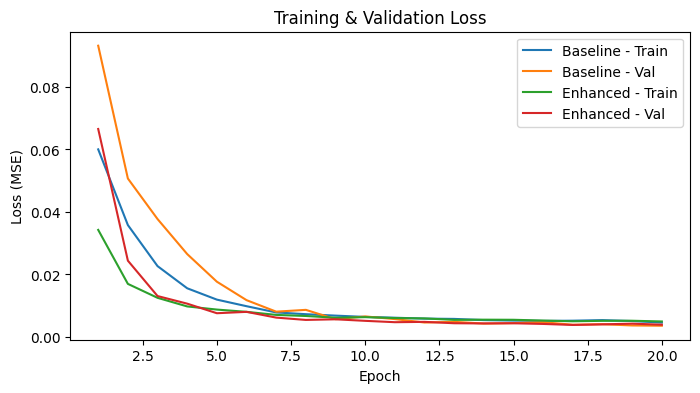

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), baseline_train_losses, label="Baseline - Train")
plt.plot(range(1, num_epochs+1), baseline_val_losses, label="Baseline - Val")
plt.plot(range(1, num_epochs+1), enhanced_train_losses, label="Enhanced - Train")
plt.plot(range(1, num_epochs+1), enhanced_val_losses, label="Enhanced - Val")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

#### SSIM & PSNR

In [12]:
def compare_ssim_psnr(models, data_loader, device, labels=None):
    results = []
    for i, model in enumerate(models):
        label = labels[i] if labels else f"Model {i+1}"
        model.eval()
        ssim_scores = []
        psnr_scores = []

        with torch.no_grad():
            for batch in data_loader:
                if isinstance(batch, (list, tuple)):
                    batch = batch[0]
                batch = batch.to(device)
                _, output = model(batch)
                ssim_val = piq.ssim(output, batch, data_range=1.)
                psnr_val = piq.psnr(output, batch, data_range=1.)
                ssim_scores.append(ssim_val.item())
                psnr_scores.append(psnr_val.item())

        avg_ssim = sum(ssim_scores) / len(ssim_scores)
        avg_psnr = sum(psnr_scores) / len(psnr_scores)
        
        results.append({
            "Model": label,
            "Average SSIM": round(avg_ssim, 4),
            "Average PSNR (dB)": round(avg_psnr, 2)
        })

    df = pd.DataFrame(results)
    return df


compare_ssim_psnr(
    models=[baseline_model, enhanced_model],
    data_loader=test_loader,
    device=device,
    labels=["Baseline", "Enhanced"]
)


Model  Average SSIM  Average PSNR (dB)
0  Baseline        0.6097              24.62
1  Enhanced        0.6516              24.26

#### MSE loss & visualise reconstructions


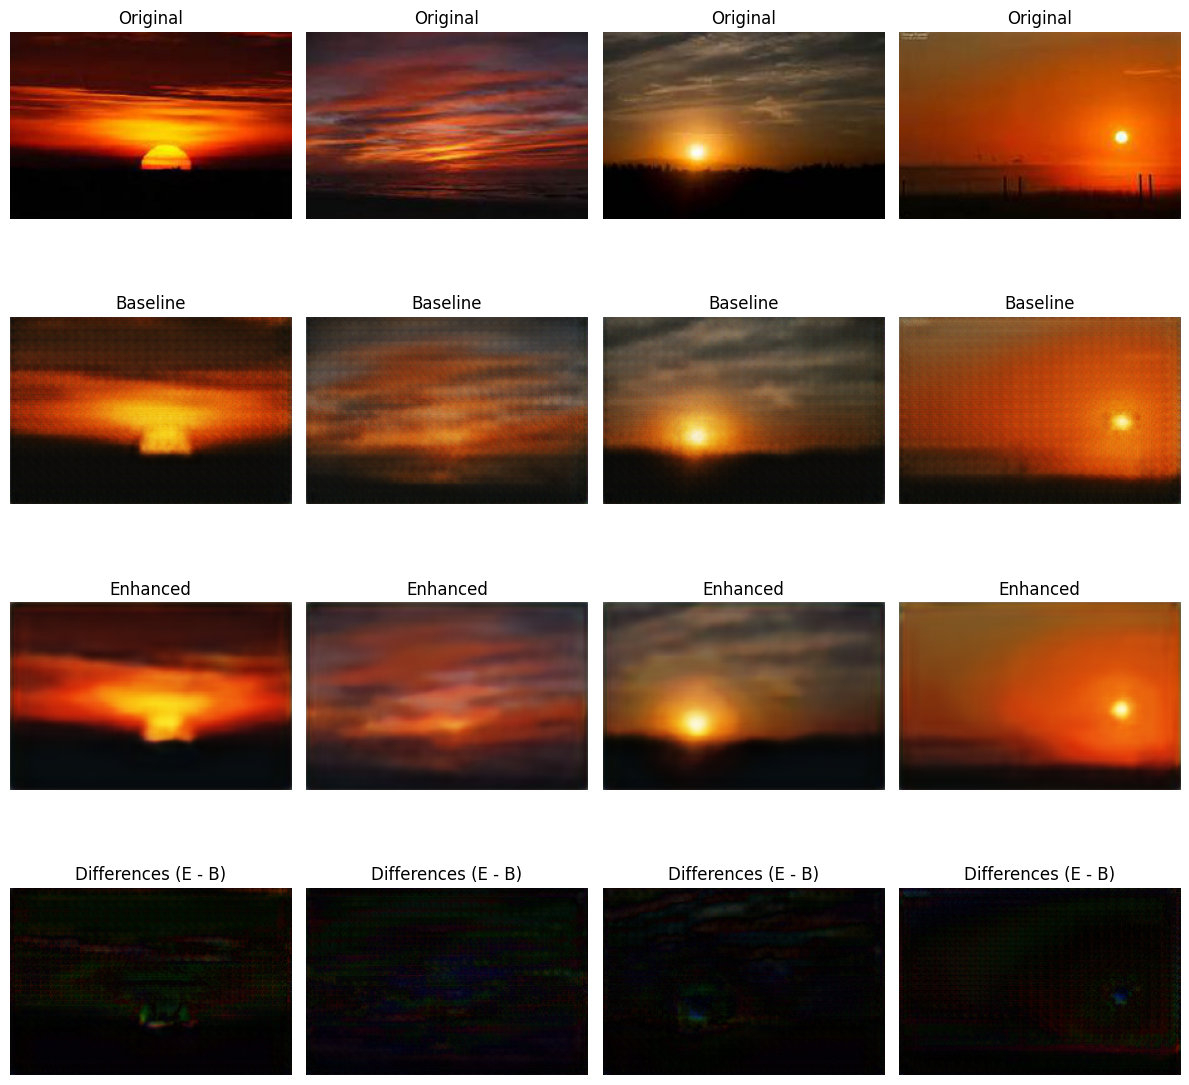

In [13]:
def compare_model_reconstructions(model1, model2, loader, device, num_images=4):
    model1.eval()
    model2.eval()

    with torch.no_grad():
        batch, = next(iter(loader))
        batch = batch.to(device)
        _, recon1 = model1(batch)
        _, recon2 = model2(batch)

    orig = batch.cpu().numpy()
    recon1 = recon1.cpu().numpy()
    recon2 = recon2.cpu().numpy()

    fig, axs = plt.subplots(4, num_images, figsize=(num_images * 3, 12))
    for i in range(num_images):
        axs[0, i].imshow(np.transpose(orig[i], (1, 2, 0)))
        axs[0, i].axis('off')
        axs[0, i].set_title('Original')

        axs[1, i].imshow(np.transpose(recon1[i], (1, 2, 0)))
        axs[1, i].axis('off')
        axs[1, i].set_title('Baseline')

        axs[2, i].imshow(np.transpose(recon2[i], (1, 2, 0)))
        axs[2, i].axis('off')
        axs[2, i].set_title('Enhanced')
        
        diff = np.abs(recon1[i] - recon2[i])
        axs[3, i].imshow(np.transpose(diff, (1, 2, 0)), cmap='inferno')
        axs[3, i].axis('off')
        axs[3, i].set_title('Differences (E - B)')

    plt.tight_layout()
    plt.show()


compare_model_reconstructions(
    baseline_model,
    enhanced_model,
    test_loader,
    device,
    num_images=4
)

#### Show evolution of reconstruction on a fixed validation batch over epochs


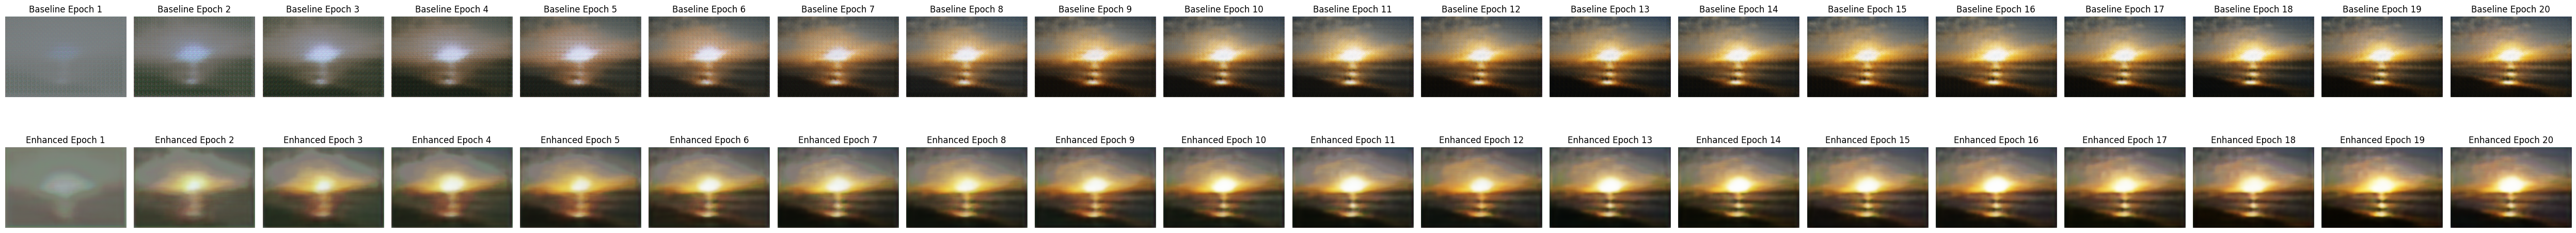

In [14]:
def compare_training_progress(sample1, sample2, fixed_batch, num_epochs, num_images=3):
    fixed_batch_np = fixed_batch.cpu().numpy()
    num_images = min(num_images, fixed_batch.size(0))

    fig, axs = plt.subplots(2, num_epochs, figsize=(num_epochs * 2.5, 6))

    for epoch in range(1, num_epochs + 1):
        recon1 = sample1[epoch].cpu().numpy()
        recon2 = sample2[epoch].cpu().numpy()

        for idx in range(num_images):

            axs[0, epoch - 1].imshow(np.transpose(recon1[idx], (1, 2, 0)))
            axs[0, epoch - 1].axis('off')
            axs[0, epoch - 1].set_title(f"Baseline Epoch {epoch}")

            axs[1, epoch - 1].imshow(np.transpose(recon2[idx], (1, 2, 0)))
            axs[1, epoch - 1].axis('off')
            axs[1, epoch - 1].set_title(f"Enhanced Epoch {epoch}")


    plt.tight_layout()
    plt.show()


compare_training_progress(
    sample1=baseline_samples,
    sample2=enhanced_samples,
    fixed_batch=baseline_fixed_batch,
    num_epochs=num_epochs,
    num_images=1
)


#### Compression ratio

In [15]:
def compare_compression_ratios(model1, model2, input_shape=(3, 150, 225), device='cpu'):
    x = torch.randn(1, *input_shape).to(device)

    with torch.no_grad():
        encoded1, _ = model1(x)
        encoded2, _ = model2(x)

    input_size = np.prod(input_shape)
    latent1_size = np.prod(encoded1.shape[1:])
    latent2_size = np.prod(encoded2.shape[1:])

    cr1 = input_size / latent1_size
    cr2 = input_size / latent2_size

    df = pd.DataFrame({
        "Model": ["Baseline", "Enhanced"],
        "Input Size": [input_size, input_size],
        "Latent Size": [latent1_size, latent2_size],
        "Compression Ratio": [f"{cr1:.2f}:1", f"{cr2:.2f}:1"]
    })

    return df

compare_compression_ratios(baseline_model, enhanced_model, device=device)


Model  Input Size  Latent Size Compression Ratio
0  Baseline      101250        68096            1.49:1
1  Enhanced      101250        64512            1.57:1

## 8. Sava Models and Loggings


In [16]:
# Save baseline model
torch.save(baseline_model.state_dict(), 'baseline_model.pth')
torch.save({
    'train_losses': baseline_train_losses,
    'val_losses': baseline_val_losses,
    'sample_reconstructions': baseline_samples,
    'fixed_batch': baseline_fixed_batch.cpu(),
}, 'baseline_logs.pth')

# Save enhanced model
torch.save(enhanced_model.state_dict(), 'enhanced_model.pth')
torch.save({
    'train_losses': enhanced_train_losses,
    'val_losses': enhanced_val_losses,
    'sample_reconstructions': enhanced_samples,
    'fixed_batch': baseline_fixed_batch.cpu(),  # reuse same fixed batch
}, 'enhanced_logs.pth')
